In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook

import wntr
import wntr.network.base as base
import wntr.network.controls as controls
import wntr.network.elements as elements

In [2]:
ewn = wntr.network.WaterNetworkModel() 

In [3]:
#Define Demand patterns
ewn.add_pattern('flat',[1])
ewn.add_pattern('linear',[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,
                         0.85,0.9,0.95,1,1.05,1.1,1.15,1.2,1.25])
ewn.add_pattern('realistic',
               [0.644,0.404,0.25 ,0.176,0.152,0.289,0.93 ,1.396,1.469,1.476,1.453,1.424,
                1.392,1.361, 1.278,1.143,1.134,1.19 ,1.247,1.295,1.318,1.323,1.114,0.905])



In [4]:
#Add Nodes
for i in range(1,3):
    for j in range(1,3):
        name = 'n' + str(2*(i-1)+(j-1)+1)
        ewn.add_junction(name, base_demand=0.01*i*j,
                        demand_pattern='flat',
                        elevation=100,
                        coordinates=(i,j)) 

In [5]:
#Add the reservioir to the network
ewn.add_reservoir('R1', base_head = 125, head_pattern='pat1', coordinates=(1,4))

In [6]:
#Adding pipes on Nodes 
ewn.add_pipe('p1', 'n1', 'n2',
            length=100, diameter=0.5,roughness=100, minor_loss=0.0, status='OPEN')
ewn.add_pipe('p2', 'n1', 'n3',
            length=100, diameter=0.5,roughness=100, minor_loss=0.0, status='OPEN')
ewn.add_pipe('p3', 'n2', 'n4',
            length=100, diameter=0.5,roughness=100, minor_loss=0.0, status='OPEN')
ewn.add_pipe('p4', 'n3', 'n4',
            length=100, diameter=0.5,roughness=100, minor_loss=0.0, status='OPEN')
ewn.add_pipe('p5', 'R1', 'n2',
            length=100, diameter=0.5,roughness=100, minor_loss=0.0, status='OPEN')



<IPython.core.display.Javascript object>


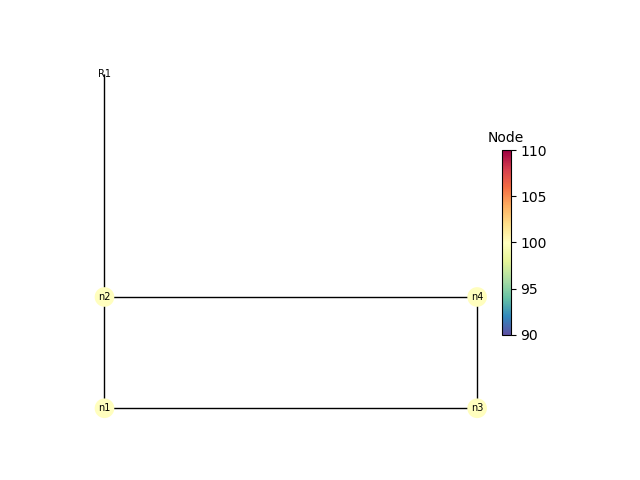

(<matplotlib.collections.PathCollection at 0x1024fefbd0>,
 <matplotlib.collections.LineCollection at 0x1025022110>)

In [7]:
#Plot the Network
wntr.graphics.plot_network(ewn, node_size = 200, node_labels = True, node_attribute = 'elevation')

In [8]:
#Modifying the network
sel_node = [ewn.get_node('n1'),ewn.get_node('n3')]
sel_node[0].elevation = 90
sel_node[1].elevation = 103

pat = ewn.get_pattern('realistic')
sel_node[0].demand_timeseries_list.append((0.2,pat))
sel_node[1].demand_timeseries_list.append((0.15,pat))


<IPython.core.display.Javascript object>


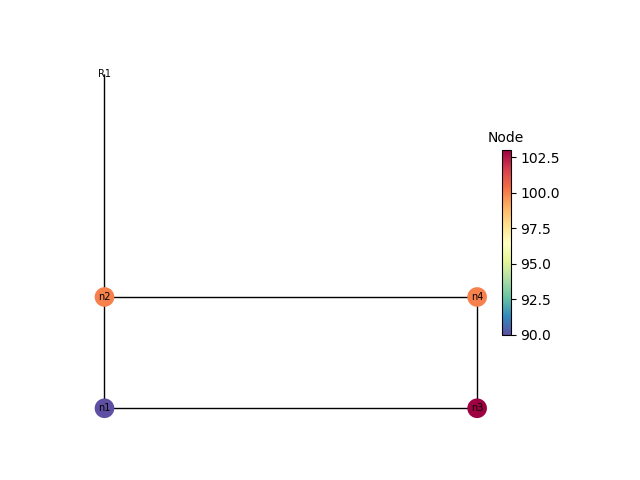

(<matplotlib.collections.PathCollection at 0x1024fef510>,
 <matplotlib.collections.LineCollection at 0x102537bf50>)

In [9]:
#Plot the modified Network
wntr.graphics.plot_network(ewn, node_size = 200, node_labels = True,
                          node_attribute ='elevation')

In [10]:
#Adding Pressure Reduction Valves
ewn.add_junction('n5', base_demand=0.1,
                        demand_pattern='realistic',
                        elevation=50,
                        coordinates=(2,5))

ewn.add_valve('PRV_1', 'n4', 'n5', diameter=0.15, valve_type='PRV', minor_loss=0.0, setting=35)

In [11]:
#Add Tank as Buffers
ewn.add_tank('T_1', elevation=200, coordinates=(5,1),
            init_level=3, min_level=1, max_level=4, diameter=16)

In [12]:
#Adding Head_Pump
ewn.add_junction('n6', base_demand=0.1,
                        demand_pattern='realistic',
                        elevation=200,
                        coordinates=(6,1))

ewn.add_pipe('p6', 'T_1', 'n6',
            length=100, diameter=0.5,roughness=100, minor_loss=0.0, status='OPEN')

ewn.add_curve('PUMP_1_curve', 'HEAD', [(0.00,126.67),(0.0076,88.67),(0.0138,0.00)])

ewn.add_pump('PUMP_1', 'n3', 'T_1', pump_type='HEAD', pump_parameter='PUMP_1_curve')

In [13]:
#Control Conditions
condition = controls.ValueCondition(ewn.get_node('T_1'),'level','>=',3.9)
action = controls.ControlAction(ewn.get_link('PUMP_1'), 'status', base.LinkStatus(0))
control = controls.Control(condition, action, priority=3)
ewn.add_control('CONTROL_1', control)

In [14]:
#Control Check
for control in ewn.controls():
    print(control)

('CONTROL_1', <Control: '', <ValueCondition: T_1, level, >=, 3.9>, [<ControlAction: PUMP_1, status, Closed>], [], priority=3>)


In [15]:
#Control Conditions
condition = controls.ValueCondition(ewn.get_node('T_1'),'level','<=',2.4)
action = controls.ControlAction(ewn.get_link('PUMP_1'), 'status', base.LinkStatus(1))
control = controls.Control(condition, action, priority=3)
ewn.add_control('CONTROL_2', control)

In [16]:
#Control Check
for control in ewn.controls():
    print(control)

('CONTROL_1', <Control: '', <ValueCondition: T_1, level, >=, 3.9>, [<ControlAction: PUMP_1, status, Closed>], [], priority=3>)
('CONTROL_2', <Control: '', <ValueCondition: T_1, level, <=, 2.4>, [<ControlAction: PUMP_1, status, Open>], [], priority=3>)


<IPython.core.display.Javascript object>


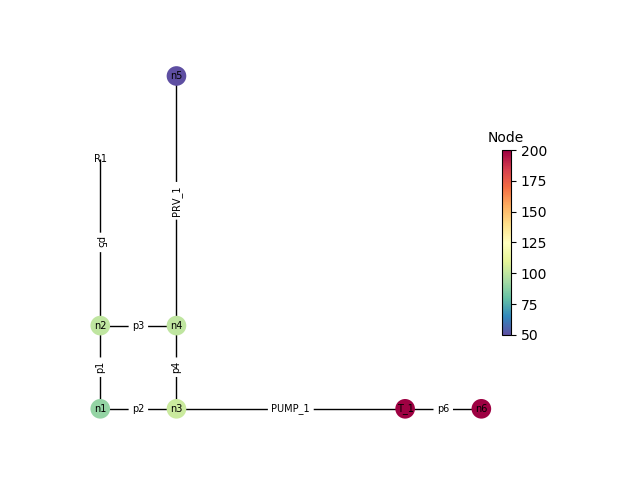

(<matplotlib.collections.PathCollection at 0x1025527c10>,
 <matplotlib.collections.LineCollection at 0x10256cab10>)

In [17]:
#Network Plot
wntr.graphics.plot_network(ewn, node_size=200, node_labels=True, link_labels=True, node_attribute='elevation')

In [18]:
#Save file format
ewn.options.hydraulic.en2_units = 'CMH'

ewn.write_inpfile('My_Hometown.inp')